<a href="https://colab.research.google.com/github/aniruddh-shukla/ATML-proj/blob/main/ATiML_consolidated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install auto-sklearn
!pip install gensim
!pip install scikit-learn==0.24.2
!pip install dask distributed --upgrade

     |████████████████████████████████| 6.1MB 6.3MB/s 
     |████████████████████████████████| 22.3MB 1.7MB/s 
     |████████████████████████████████| 706kB 23.6MB/s 
     |████████████████████████████████| 4.2MB 35.6MB/s 
     |████████████████████████████████| 4.0MB 42.8MB/s 
     |████████████████████████████████| 266kB 54.3MB/s 
  Created wheel for auto-sklearn: filename=auto_sklearn-0.12.6-cp37-none-any.whl size=6370105 sha256=cbfe4197a4a61c83468462e8de6038bb050a39d94d9ccc9500b718f0f804933f
  Stored in directory: /root/.cache/pip/wheels/5f/c8/1f/3a6d11c1e156bf431e7cc4c4ff27e71059acc9638caa11ab35
  Created wheel for liac-arff: filename=liac_arff-2.5.0-cp37-none-any.whl size=11732 sha256=69f45fc6b11a5ebf44208a9a381c9601ef01589729a2a10115e5e374b78fa83b
  Stored in directory: /root/.cache/pip/wheels/77/8d/b4/8bfce5beea9a3496cc15b24961876adb7b6e2912ff09164179
  Created wheel for pynisher: filename=pynisher-0.6.4-cp37-none-any.whl size=7045 sha256=734f9b51263ca3f31bc0b0044f2121417da29b9

In [10]:
import re
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from tabulate import tabulate

from os import listdir
from os.path import isfile, join
import string

# dataset
from sklearn.datasets import fetch_20newsgroups

### Pre-processing
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD
from collections import Counter

## Classifiers
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC

##Evaluation
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score

In [11]:
# SpaCy Packages
import spacy 
import spacy.cli
spacy.cli.download("en_core_web_md")
# Gensim packages
from gensim.parsing import strip_tags, strip_numeric, strip_multiple_whitespaces, stem_text, strip_punctuation, remove_stopwords
from gensim.parsing import preprocess_string

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


In [12]:
# loading dataset
news_group = fetch_20newsgroups(subset='train')

news_group_data = news_group.data
news_group_target_names = news_group.target_names
news_group_target = news_group.target

# Creating a dataframe from the loaded data
news_df = pd.DataFrame({'desc': news_group_data, 
                        'class': news_group_target})

In [13]:
news_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11314 entries, 0 to 11313
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   desc    11314 non-null  object
 1   class   11314 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 176.9+ KB


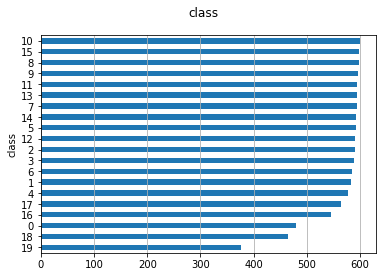

In [5]:
#Class distribution Visualization
x = "class"

fig, ax = plt.subplots()
fig.suptitle(x, fontsize=12)
news_df[x].reset_index().groupby(x).count().sort_values(by= 
       "index").plot(kind="barh", legend=False, 
        ax=ax).grid(axis='x')
plt.show()

In [6]:
# Clean header
def clean_header(text):
    text = re.sub(r'(From:\s+[^\n]+\n)', '', text)
    text = re.sub(r'(Subject:[^\n]+\n)', '', text)
    text = re.sub(r'(([\sA-Za-z0-9\-]+)?[A|a]rchive-name:[^\n]+\n)', '', text)
    text = re.sub(r'(Last-modified:[^\n]+\n)', '', text)
    text = re.sub(r'(Version:[^\n]+\n)', '', text)
    text = re.sub(r'(lines:[^\n]+\n)', '', text)
    return text

news_df['desc'] =  news_df['desc'].apply(clean_header)

In [7]:
news_df['desc'].head()

0    Nntp-Posting-Host: rac3.wam.umd.edu\nOrganizat...
1    Summary: Final call for SI clock reports\nKeyw...
2    Organization: Purdue University Engineering Co...
3    Organization: Harris Computer Systems Division...
4    Organization: Smithsonian Astrophysical Observ...
Name: desc, dtype: object

In [8]:
# Custom filter method
transform_to_lower = lambda s: s.lower() #upper to lower case

remove_single_char = lambda s: re.sub(r'\s+\w{1}\s+', '', s) #regex to remove single char
remove_double_char = lambda s: re.sub(r'\s+\w{2}\s+', '', s) #regex to remove double char
strip_non_alphanum =lambda s: re.sub(r"^[a-zA-Z0-9_]*$", '',s)
remove_url = lambda s: re.sub(r'(?:http|ftp|https)://(?:[\w_-]+(?:(?:\.[\w_-]+)+))(?:[\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?', '',s)
remove_email = lambda s: re.sub('(?:[a-z0-9!#$%&\'*+/=?^_`{|}~-]+(?:\.[a-z0-9!#$%&\'*+/=?^_`{|}~-]+)*|"(?:[\x01-\x08\x0b\x0c\x0e-\x1f\x21\x23-\x5b\x5d-\x7f]|\\[\x01-\x09\x0b\x0c\x0e-\x7f])*")@(?:(?:[a-z0-9](?:[a-z0-9-]*[a-z0-9])?\.)+[a-z0-9](?:[a-z0-9-]*[a-z0-9])?|\[(?:(?:(2(5[0-5]|[0-4][0-9])|1[0-9][0-9]|[1-9]?[0-9]))\.){3}(?:(2(5[0-5]|[0-4][0-9])|1[0-9][0-9]|[1-9]?[0-9])|[a-z0-9-]*[a-z0-9]:(?:[\x01-\x08\x0b\x0c\x0e-\x1f\x21-\x5a\x53-\x7f]|\\[\x01-\x09\x0b\x0c\x0e-\x7f])+)\])', '', s)

# Filters to be executed in pipeline
CLEAN_FILTERS = [
#                 strip_tags
#                ,strip_numeric
#                ,strip_punctuation
#                ,strip_multiple_whitespaces
#                ,transform_to_lower
                remove_stopwords
#                ,remove_single_char
#                ,remove_url
#                ,remove_email
#                ,strip_non_alphanum
#                 ,remove_double_char
#                ,stem_text
] #stemming text

# Method does the filtering of all the unrelevant text elements
def cleaning_pipe(document):
    # Invoking gensim.parsing.preprocess_string method with set of filters
    processed_words = preprocess_string(document, CLEAN_FILTERS)
    
    return processed_words

In [14]:
train_df, test_df = train_test_split(news_df, test_size=0.1, random_state=42, stratify=news_df["class"])
train_data = train_df["desc"]
train_target = train_df["class"]
test_data = test_df["desc"]
test_target = test_df["class"]

In [54]:
import numpy as np

with open('/content/drive/MyDrive/ATiML_Proj/glove.6B.50d.txt', "rb") as lines:
    w2v = {line.split()[0]: np.array(map(float, line.split()[1:]))
           for line in lines}


In [55]:
import gensim
# let X be a list of tokenized texts (i.e. list of lists of tokens)
model = gensim.models.Word2Vec(news_df['desc'].apply(cleaning_pipe), size=100, window=5, min_count=5, workers=2)
w2v = dict(zip(model.wv.index2word, model.wv.syn0))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  after removing the cwd from sys.path.


In [56]:
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = len(word2vec.items())

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

In [57]:
class TfidfEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.word2weight = None
        self.dim = len(word2vec.items())

    def fit(self, X, y):
        tfidf = TfidfVectorizer(analyzer=lambda x: x)
        tfidf.fit(X)
        # if a word was never seen - it must be at least as infrequent
        # as any of the known words - so the default idf is the max of 
        # known idf's
        max_idf = max(tfidf.idf_)
        self.word2weight = defaultdict(
            lambda: max_idf,
            [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])

        return self

    def transform(self, X):
        return np.array([
                np.mean([self.word2vec[w] * self.word2weight[w]
                         for w in words if w in self.word2vec] or
                        [np.zeros(self.dim)], axis=0)
                for words in X
            ])


In [58]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import ExtraTreesClassifier

etree_w2v = Pipeline([
    ("word2vec vectorizer", MeanEmbeddingVectorizer(w2v)),
    ("extra trees", ExtraTreesClassifier(n_estimators=200))])
etree_w2v_tfidf = Pipeline([
    ("word2vec vectorizer", TfidfEmbeddingVectorizer(w2v)),
    ("extra trees", ExtraTreesClassifier(n_estimators=200))])


In [59]:
mult_nb = Pipeline([("count_vectorizer", CountVectorizer(preprocessor= cleaning_pipe,analyzer=lambda x: x)), ("multinomial nb", MultinomialNB())])
bern_nb = Pipeline([("count_vectorizer", CountVectorizer(preprocessor= cleaning_pipe,analyzer=lambda x: x)), ("bernoulli nb", BernoulliNB())])
mult_nb_tfidf = Pipeline([("tfidf_vectorizer", TfidfVectorizer(preprocessor= cleaning_pipe,analyzer=lambda x: x)), ("multinomial nb", MultinomialNB())])
bern_nb_tfidf = Pipeline([("tfidf_vectorizer", TfidfVectorizer(preprocessor= cleaning_pipe,analyzer=lambda x: x)), ("bernoulli nb", BernoulliNB())])
svc = Pipeline([("count_vectorizer", CountVectorizer(preprocessor= cleaning_pipe, analyzer=lambda x: x)), ("linear svc", SVC(kernel="linear"))])
svc_tfidf = Pipeline([("tfidf_vectorizer", TfidfVectorizer(preprocessor= cleaning_pipe, analyzer=lambda x: x)), ("linear svc", SVC(kernel="linear"))])

In [62]:
%%bash
wget http://www.cs.umb.edu/~smimarog/textmining/datasets/20ng-test-no-stop.txt
wget http://www.cs.umb.edu/~smimarog/textmining/datasets/20ng-train-no-stop.txt

--2021-05-28 00:18:06--  http://www.cs.umb.edu/~smimarog/textmining/datasets/20ng-test-no-stop.txt
Resolving www.cs.umb.edu (www.cs.umb.edu)... 158.121.106.224
Connecting to www.cs.umb.edu (www.cs.umb.edu)|158.121.106.224|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.cs.umb.edu:443/~smimarog/textmining/datasets/20ng-test-no-stop.txt [following]
--2021-05-28 00:18:06--  https://www.cs.umb.edu/~smimarog/textmining/datasets/20ng-test-no-stop.txt
Connecting to www.cs.umb.edu (www.cs.umb.edu)|158.121.106.224|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2021-05-28 00:18:07 ERROR 404: Not Found.

--2021-05-28 00:18:07--  http://www.cs.umb.edu/~smimarog/textmining/datasets/20ng-train-no-stop.txt
Resolving www.cs.umb.edu (www.cs.umb.edu)... 158.121.106.224
Connecting to www.cs.umb.edu (www.cs.umb.edu)|158.121.106.224|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.cs.umb.edu:443/~sm

In [60]:
cv = StratifiedShuffleSplit( test_size=0.2, random_state=42)
##BenchMark

all_models = [
#    ("mult_nb", mult_nb),
#    ("mult_nb_tfidf", mult_nb_tfidf),
#    ("bern_nb", bern_nb),
#    ("bern_nb_tfidf", bern_nb_tfidf),
    #("svc", svc),
    #("svc_tfidf", svc_tfidf),
    ("w2v", etree_w2v),
    ("w2v_tfidf", etree_w2v_tfidf),
]
scores = sorted([(name, cross_val_score(model, train_data, train_target, scoring="accuracy", cv=5).mean()) for name, model in all_models])
print (tabulate(scores, floatfmt=".4f", headers=("model", 'accuracy')))

model        accuracy
---------  ----------
w2v            0.2262
w2v_tfidf      0.2374


In [ ]:
import autosklearn.classification

automl = autosklearn.classification.AutoSklearnClassifier()

In [ ]:
#BOW pipeline
bow_pipeline = Pipeline(
    steps=[
        ("tfidf", TfidfVectorizer(preprocessor=cleaning_pipe,analyzer=lambda x: x)),
        ("classifier", automl),
    ]
)
bow_pipeline.fit(train_data, train_target)
y_pred = bow_pipeline.predict(test_data)
cr = classification_report(test_target, y_pred)
print('Classification report:\n\n{}'.format(
    classification_report(test_target, y_pred))
)

In [10]:
nlp = spacy.load("en_core_web_md")  # this model will give you 300D

class SpacyVectorTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, nlp):
        self.nlp = nlp
        self.dim = 100

    def fit(self, X, y):
        X = X.apply(cleaning_pipe)
        return X

    def transform(self, X):
        # Doc.vector defaults to an average of the token vectors.
        # https://spacy.io/api/doc#vector
        return [self.nlp(text).vector for text in X]

In [11]:
from sklearn import metrics, svm

ftree_glove = Pipeline(
    steps=[
        ("mean_embeddings", SpacyVectorTransformer(nlp)),
        ("reduce_dim", TruncatedSVD(50)),
        ("classifier", automl),
        
    ])

NameError: ignored

In [ ]:
ftree_glove.fit(train_data, train_target)

In [ ]:
y_pred = ftree_glove.predict(test_data)
print('Classification report:\n\n{}'.format(
    classification_report(test_target, y_pred))
)

In [ ]:
#BOW pipeline
bow_pipeline = Pipeline(
    steps=[
        ("tfidf", TfidfVectorizer(preprocessor=cleaning_pipe,analyzer=lambda x: x)),
        ("classifier", SVC(kernel="linear")),
    ]
)
bow_pipeline.fit(train_data, train_target)
y_pred = bow_pipeline.predict(test_data)
cr = classification_report(test_target, y_pred)
print('Classification report:\n\n{}'.format(
    classification_report(test_target, y_pred))
)

Classification report:

              precision    recall  f1-score   support

           0       0.33      0.35      0.34        48
           1       0.13      0.16      0.14        58
           2       0.22      0.12      0.15        59
           3       0.23      0.19      0.21        59
           4       0.39      0.16      0.22        58
           5       0.44      0.25      0.32        59
           6       0.35      0.47      0.40        59
           7       0.14      0.19      0.16        59
           8       0.28      0.35      0.31        60
           9       0.29      0.27      0.28        60
          10       0.19      0.08      0.11        60
          11       0.19      0.62      0.29        60
          12       0.23      0.10      0.14        59
          13       0.32      0.22      0.26        59
          14       0.11      0.05      0.07        59
          15       0.26      0.72      0.38        60
          16       0.21      0.13      0.16        55
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
#BOW pipeline
bow_pipeline = Pipeline(
    steps=[
        ("tfidf", TfidfVectorizer(preprocessor=cleaning_pipe,analyzer=lambda x: x)),
        ("classifier", RandomForestClassifier()),
    ]
)
bow_pipeline.fit(train_data, train_target)
y_pred = bow_pipeline.predict(test_data)
cr = classification_report(test_target, y_pred)
print('Classification report:\n\n{}'.format(
    classification_report(test_target, y_pred))
)

Classification report:

              precision    recall  f1-score   support

           0       0.26      0.25      0.26        48
           1       0.18      0.21      0.19        58
           2       0.39      0.42      0.41        59
           3       0.31      0.29      0.30        59
           4       0.27      0.26      0.27        58
           5       0.48      0.69      0.57        59
           6       0.46      0.66      0.54        59
           7       0.30      0.22      0.25        59
           8       0.50      0.62      0.55        60
           9       0.37      0.42      0.39        60
          10       0.48      0.48      0.48        60
          11       0.33      0.50      0.40        60
          12       0.28      0.14      0.18        59
          13       0.35      0.27      0.30        59
          14       0.33      0.27      0.30        59
          15       0.44      0.68      0.53        60
          16       0.49      0.38      0.43        55
   

Classification report:

              precision    recall  f1-score   support

           0       0.47      0.44      0.45        48
           1       0.34      0.36      0.35        58
           2       0.51      0.51      0.51        59
           3       0.47      0.46      0.46        59
           4       0.46      0.43      0.45        58
           5       0.62      0.58      0.60        59
           6       0.54      0.64      0.58        59
           7       0.47      0.32      0.38        59
           8       0.64      0.65      0.64        60
           9       0.46      0.52      0.48        60
          10       0.51      0.58      0.55        60
          11       0.63      0.63      0.63        60
          12       0.45      0.49      0.47        59
          13       0.41      0.56      0.47        59
          14       0.51      0.44      0.47        59
          15       0.57      0.67      0.62        60
          16       0.56      0.53      0.54        55
   

In [ ]:
import sklearn.metrics
y_hat = bow_pipeline.predict(test_data)

print("Accuracy score", sklearn.metrics.accuracy_score(test_target, y_hat))

Accuracy score 0.5220848056537103


In [ ]:
from gensim.models.word2vec import Word2Vec
# train word2vec on all the texts - both training and test set
# we're not using test labels, just texts so this is fine
model = Word2Vec(train_data, size=100, window=5, min_count=5, workers=2)
model.wv.index2word
w2v = {w: vec for w, vec in zip(model.wv.index2word, model.wv.syn0)}

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  


In [ ]:
all_models = [
    ("ftree_glove", ftree_glove),
    
]

scores = sorted([(name, cross_val_score(model, train_data, train_target, scoring="accuracy", cv=cv).mean())
                 for name, model in all_models])
print (tabulate(scores, floatfmt=".4f", headers=("model", 'accuracy')))

In [ ]:
import spacy 
from sklearn.base import BaseEstimator, TransformerMixin
nlp = spacy.load("en_core_web_md")  # this model will gives you 300D

cv = StratifiedShuffleSplit(n_splits=100, test_size=0.1, random_state=42)

class SpacyVectorTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, nlp):
        self.nlp = nlp
        self.dim = 300

    def fit(self, X, y):
        return self

    def transform(self, X):
        # Doc.vector defaults to an average of the token vectors.
        # https://spacy.io/api/doc#vector
        return [self.nlp(text).vector for text in X]

ftree_glove = Pipeline([("mean_embeddings", SpacyVectorTransformer(nlp)),("reduce_dim", TruncatedSVD(50)),("classifier", RandomForestClassifier()),])

all_models = [
    ("ftree_glove", ftree_glove),
    
]

scores = sorted([(name, cross_val_score(model, train_data, train_target, scoring="accuracy", cv=cv).mean())
                 for name, model in all_models])


In [ ]:
print (tabulate(scores, floatfmt=".4f", headers=("model", 'accuracy')))

In [ ]:
svc = Pipeline([("count_vectorizer", CountVectorizer(analyzer=lambda x: x)), ("linear svc", SVC(kernel="linear"))])
svc_tfidf = Pipeline([("tfidf_vectorizer", TfidfVectorizer(analyzer=lambda x: x)), ("linear svc", SVC(kernel="linear"))])

In [ ]:
!unzip /content/gdrive/MyDrive/ATiML_Proj/glove*.zip

unzip:  cannot find or open /content/gdrive/MyDrive/ATiML_Proj/glove*.zip, /content/gdrive/MyDrive/ATiML_Proj/glove*.zip.zip or /content/gdrive/MyDrive/ATiML_Proj/glove*.zip.ZIP.

No zipfiles found.


In [ ]:
print('Indexing word vectors.')

embeddings_index = {}
f = open('/content/drive/MyDrive/ATiML_Proj/glove.6B.50d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Indexing word vectors.
Found 400000 word vectors.


In [15]:
!pip install --upgrade scikit-learn

Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.7/dist-packages (0.24.2)


In [16]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.semi_supervised import LabelSpreading
from sklearn.metrics import f1_score
from sklearn.semi_supervised import LabelPropagation


# Parameters
sdg_params = dict(alpha=1e-5, penalty='l2', loss='log')
vectorizer_params = dict(ngram_range=(1, 2), min_df=5, max_df=0.8)

In [17]:
import spacy 
from sklearn.base import BaseEstimator, TransformerMixin
nlp = spacy.load("en_core_web_md")  # this model will gives you 300D

class SpacyVectorTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, nlp):
        self.nlp = nlp
        self.dim = 300

    def fit(self, X, y):
        return self

    def transform(self, X):
        # Doc.vector defaults to an average of the token vectors.
        # https://spacy.io/api/doc#vector
        return [self.nlp(text).vector for text in X]

In [20]:
# Supervised Pipeline
pipeline = Pipeline([
    ("mean_embeddings", SpacyVectorTransformer(nlp)),
    ("reduce_dim", TruncatedSVD(50)),
    ('clf', SGDClassifier(**sdg_params)),
])
# SelfTraining Pipeline
st_pipeline = Pipeline([
    ("mean_embeddings", SpacyVectorTransformer(nlp)),
    ("reduce_dim", TruncatedSVD(50)),
    ('clf', SelfTrainingClassifier(SGDClassifier(**sdg_params), verbose=True)),
])
# LabelSpreading Pipeline
lp_pipeline = Pipeline([
    ("mean_embeddings", SpacyVectorTransformer(nlp)),
    ("reduce_dim", TruncatedSVD(50)),
    # LabelSpreading does not support dense matrices
    ('todense', FunctionTransformer(lambda x: x.todense())),
    ('clf', LabelPropagation(max_iter=2000)),
])

In [21]:
def eval_and_print_metrics(clf, X_train, y_train, X_test, y_test):
    print("Number of training samples:", len(X_train))
    print("Unlabeled samples in training set:",
          sum(1 for x in y_train if x == -1))
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print("Micro-averaged F1 score on test set: "
          "%0.3f" % f1_score(y_test, y_pred, average='micro'))
    print("-" * 10)
    print()


if __name__ == "__main__":

    print("Supervised SGDClassifier on 100% of the data:")
    eval_and_print_metrics(pipeline, train_data, train_target, test_data, test_target)

    # select a mask of 20% of the train dataset
    y_mask = np.random.rand(len(train_target)) < 0.2

    # X_20 and y_20 are the subset of the train dataset indicated by the mask
    X_20, y_20 = map(list, zip(*((x, y)
                     for x, y, m in zip(train_data, train_target, y_mask) if m)))
    print("Supervised SGDClassifier on 20% of the training data:")
    eval_and_print_metrics(pipeline, X_20, y_20, test_data, test_target)

    # set the non-masked subset to be unlabeled
    train_target[~y_mask] = -1
    print("SelfTrainingClassifier on 20% of the training data (rest "
          "is unlabeled):")
    eval_and_print_metrics(st_pipeline, train_data, train_target, test_data, test_target)

    print("LabelSpreading on 20% of the data (rest is unlabeled):")
    eval_and_print_metrics(lp_pipeline, train_data, train_target, test_data, test_target)

Supervised SGDClassifier on 100% of the data:
Number of training samples: 10182
Unlabeled samples in training set: 0
Micro-averaged F1 score on test set: 0.595
----------

Supervised SGDClassifier on 20% of the training data:
Number of training samples: 2040
Unlabeled samples in training set: 0
Micro-averaged F1 score on test set: 0.539
----------

SelfTrainingClassifier on 20% of the training data (rest is unlabeled):
Number of training samples: 10182
Unlabeled samples in training set: 8142


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:1021: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(~key, value, inplace=True)


End of iteration 1, added 2563 new labels.
End of iteration 2, added 802 new labels.
End of iteration 3, added 352 new labels.
End of iteration 4, added 406 new labels.
End of iteration 5, added 183 new labels.
End of iteration 6, added 244 new labels.
End of iteration 7, added 376 new labels.
End of iteration 8, added 155 new labels.
End of iteration 9, added 42 new labels.
End of iteration 10, added 125 new labels.
Micro-averaged F1 score on test set: 0.515
----------



NameError: ignored